## Kaggle competetion
Link: https://www.kaggle.com/competitions/deep-learning-practice-image-classification/leaderboard

### Got 95% accuracy




In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# # Loop through all files in the directory
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):  # Check for image files
#             image_path = os.path.join(dirname, filename)
            
#             # Open image using PIL
#             with Image.open(image_path) as img:
#                 # Print the shape (width, height, channels)
#                 print(f"Image: {filename} - Shape: {img.size} (Width x Height)")

In [3]:
import torch
from torchvision import transforms

Image viewer

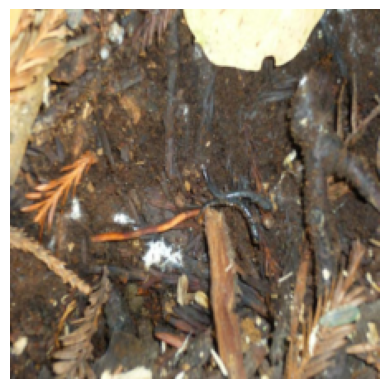

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Load an image
image_path = "/kaggle/input/deep-learning-practice-image-classification/train/Amphibia/Amphibia_image_0001.jpg"  # Replace with the path to your image
image = Image.open(image_path)

# Step 2: Apply transformations (if necessary)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()          # Convert image to a PyTorch tensor
])
image_tensor = transform(image)

# Step 3: Convert the tensor to a format suitable for visualization
# Permute the tensor dimensions from [C, H, W] to [H, W, C]
image_np = image_tensor.permute(1, 2, 0).numpy()


# Step 4: Display the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis
plt.show()


In [5]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Step 1: Set up paths
train_dir = "/kaggle/input/deep-learning-practice-image-classification/train"

# Step 2: Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(384 , scale=(0.8, 1.0)),  # Random crop with variable size
    transforms.RandomHorizontalFlip(p=0.5),              # Random horizontal flip with 50% probability
    transforms.RandomRotation(10),                       # Random rotation within a range of 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translations
    transforms.RandomGrayscale(p=0.1),                   # Randomly convert images to grayscale
    transforms.ToTensor(),                               # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # Normalize
])

# Step 3: Load the dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
num_cls = train_dataset.classes
# Step 3.1: Split the dataset into training and validation sets (90/10 split)
train_size = int(0.9 * len(train_dataset))  # Calculate 90% of the dataset size
val_size = len(train_dataset) - train_size  # Remaining 10% for validation

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Step 4: Create DataLoaders for both training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)  # No need to shuffle validation data



In [6]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights, vit_b_16, ViT_B_16_Weights

# # Step 5: Define the model (e.g., use a pre-trained ResNet)

# # model = models.resnet50(pretrained=True)
num_classes = len(num_cls)
# # # Add custom layers

# weights = EfficientNet_V2_M_Weights.IMAGENET1K_V1  # Use the default pretrained weights
# model = efficientnet_v2_m(weights=weights)

# # from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# # # Load smaller EfficientNet variant with pretrained weights
# # weights = EfficientNet_V2_S_Weights.DEFAULT
# # model = efficientnet_v2_s(weights=weights)


# torch.manual_seed(42)
# # Load the model with pretrained weights
# # model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
# # Regularization via Dropout
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.5),
#     nn.Linear(model.classifier[1].in_features, 512),  # Bottleneck
#     nn.ReLU(),
#     nn.Linear(512, num_classes)
# )
# # # Freeze all layers except for layer 4 and the fully connected layer (model.fc)
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.features[6:].parameters():  # Unfreeze block 6 onwards
#     param.requires_grad = True

# for param in model.classifier.parameters():
#     param.requires_grad = True

# for module in model.modules():
#     if isinstance(module, nn.BatchNorm2d):
#         module.eval()

# # # Unfreeze the layers you want to train (the last residual block and fc layer)
# # for param in model.layer4.parameters():  # Unfreeze layer 4
# #     param.requires_grad = True

# # for param in model.fc.parameters():  # Unfreeze fully connected layer
# #     param.requires_grad = True


# Load the pretrained weights
weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1

# Load the model with the pretrained weights
model = vit_b_16(weights=weights)
# Modify the classification head
model.heads = nn.Sequential(
    nn.Dropout(p=0.5),  # Add Dropout for regularization
    nn.Linear(model.heads.head.in_features, num_classes)  # Replace the classifier
)

# Freeze all layers by default
for param in model.parameters():
    param.requires_grad = False

# Unfreeze specific layers: for example, the last transformer encoder block
for param in model.encoder.layers[-1].parameters():  # Unfreeze the last block
    param.requires_grad = True

# Optionally unfreeze the classifier head
for param in model.heads.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:01<00:00, 200MB/s]  


In [7]:
class F1Loss(nn.Module):
    def __init__(self):
        super(F1Loss, self).__init__()

    def forward(self, logits, targets):
        """
        Compute the F1 loss.
        Args:
            logits: Predicted raw scores (before softmax) of shape [batch_size, num_classes].
            targets: True class indices of shape [batch_size].
        Returns:
            f1_loss: Differentiable F1 score loss.
        """
        # Apply softmax to logits
        probs = torch.softmax(logits, dim=1)

        # Convert targets to one-hot encoding
        targets_one_hot = torch.zeros_like(probs).scatter_(1, targets.unsqueeze(1), 1)

        # Calculate TP, FP, and FN
        tp = (probs * targets_one_hot).sum(dim=0)  # True Positives
        fp = (probs * (1 - targets_one_hot)).sum(dim=0)  # False Positives
        fn = ((1 - probs) * targets_one_hot).sum(dim=0)  # False Negatives

        # Compute F1 score
        f1 = 2 * tp / (2 * tp + fp + fn + 1e-8)  # Add epsilon to avoid division by zero
        f1_loss = 1 - f1.mean()  # Mean over all classes

        return f1_loss


In [8]:
from torch.nn import functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        # CrossEntropyLoss calculation
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [9]:
from torch.optim.lr_scheduler import OneCycleLR

# criterion = F1Loss()  # Use custom F1 loss


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Apply label smoothing

# # Define the Nadam optimizer
# optimizer = optim.NAdam(
#     filter(lambda p: p.requires_grad, model.parameters()),  # Only trainable parameters
#     lr=1e-5,  # Learning rate for fine-tuning
#     # betas=(0.9, 0.999),  # Default values for Nadam
#     # eps=1e-8,  # Small epsilon for numerical stability
#     # weight_decay=1e-4  # Regularization (L2 penalty)
# )



# Optimizer with Weight Decay
# optimizer = optim.AdamW(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=1e-4,  # Learning rate for fine-tuning
#     # betas=(0.9, 0.999),
#     # eps=1e-8,
#     # weight_decay=1e-4
# )

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the optimizer and scheduler
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),  lr=0.01, momentum=0.9, weight_decay=1e-4)

# Scheduler

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',  # Maximize validation F1-score
    factor=0.1, 
    patience=5, 
    verbose=True
)

# Step 7: Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
device


device(type='cuda')

In [12]:
from sklearn.metrics import f1_score

num_epochs = 7
best_f1 = 0.0  # To track the best F1 score for saving the model

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}")

    # Validation Phase
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect predictions and true labels for F1 score calculation
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_predictions, average="weighted")  # Weighted F1 score for imbalanced classes
    print(f"Validation Loss: {val_loss:.4f}, F1 Score: {f1*100:.2f}")

    # # Save the model if F1 score improves
    # if f1 > best_f1:
    #     best_f1 = f1
    #     torch.save(model.state_dict(), "best_model.pth")
    #     print(f"Model saved with F1 Score: {best_f1:.4f}")

    # Step the learning rate scheduler
    scheduler.step(f1)  # Step based on F1 score


Epoch [1/7], Training Loss: 0.2235
Validation Loss: 0.2045, F1 Score: 88.40
Epoch [2/7], Training Loss: 0.1470
Validation Loss: 0.1957, F1 Score: 88.89
Epoch [3/7], Training Loss: 0.1383
Validation Loss: 0.1930, F1 Score: 88.93
Epoch [4/7], Training Loss: 0.1321
Validation Loss: 0.1667, F1 Score: 91.47
Epoch [5/7], Training Loss: 0.1232
Validation Loss: 0.1699, F1 Score: 90.81
Epoch [6/7], Training Loss: 0.1165
Validation Loss: 0.1720, F1 Score: 91.10
Epoch [7/7], Training Loss: 0.1163
Validation Loss: 0.1681, F1 Score: 91.43


In [13]:
def predict_image(image_path):
    # Open the image
    image = Image.open(image_path)
    model.eval()
    # Apply transformations to the image
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the image to the same device as the model (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    
    # Step 4: Make predictions
    with torch.no_grad():  # No need to calculate gradients during inference
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
    
    return predicted.item()  # Return the predicted class index


image_path = "/kaggle/input/deep-learning-practice-image-classification/train/Aves/Aves_image_0006.jpg"  # Replace with the actual image path
predicted_class = predict_image(image_path)
print(f"Predicted class: {predicted_class}")

# Optionally, map the predicted class index to the class name
class_names = os.listdir('/kaggle/input/deep-learning-practice-image-classification/train')  # Assuming your 'train' folder contains class subfolders
print(f"Predicted class name: {class_names[predicted_class]}")

Predicted class: 3
Predicted class name: Amphibia


In [14]:
# Step 4: Process images in a directory and save predictions to a CSV
def process_images_and_generate_csv(image_dir, output_csv):
    image_filenames = sorted(fname for fname in os.listdir(image_dir) if fname.endswith(('.jpg', '.png', '.jpeg')))
    image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]
    # Prepare the list for the CSV output
    predictions = []
    
    for image_path in image_paths:
        # Extract the filename as Image_ID
        image_id = os.path.splitext(os.path.basename(image_path))[0]  # Use the filename directly
        
        # Make the prediction
        predicted_class = predict_image(image_path)

        # Append the result to the predictions list
        predictions.append([image_id, predicted_class])
    
    # Create a DataFrame and save to CSV
    df = pd.DataFrame(predictions, columns=["Image_ID", "Label"])
    df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
process_images_and_generate_csv("/kaggle/input/deep-learning-practice-image-classification/test", "21F1001709.csv")

Predictions saved to 21F1001709.csv


LeNet
AlexNet
ResNet
GoogleNet
MobileNet
VGG